### **Logistic Regression**

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/digitalent/data/clean/elongated_word_10k.csv')
X = df['news']
y = df['is_fake']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
vectorizer = TfidfVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_holdout_vectorized = vectorizer.transform(X_holdout)

logistic = LogisticRegression(solver='liblinear', random_state=42)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

scores = cross_val_score(logistic, X_train_vectorized, y_train, cv=skf, scoring='accuracy')

print(f"Cross-Validation Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

# Optional: Train on full training data and evaluate on holdout data
logistic.fit(X_train_vectorized, y_train)

# Predict on the holdout set
y_prob = logistic.predict_proba(X_holdout_vectorized)[:, 1]

cutoffs = np.linspace(0.1, 1.0, 10)

for cutoff in cutoffs:
  y_pred = (y_prob>=cutoff).astype(int)
  print(f"\n\n CUTOFF {cutoff}")
  print("\nHoldout Accuracy:", accuracy_score(y_holdout, y_pred))
  print("\nClassification Report on Holdout Set:")
  print(classification_report(y_holdout, y_pred))
  print("\nConfusion Matrix on Holdout Set:")
  print(confusion_matrix(y_holdout, y_pred))

Cross-Validation Accuracy: 0.94 (+/- 0.01)


 CUTOFF 0.1

Holdout Accuracy: 0.7955

Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      1000
           1       0.71      1.00      0.83      1000

    accuracy                           0.80      2000
   macro avg       0.85      0.80      0.79      2000
weighted avg       0.85      0.80      0.79      2000


Confusion Matrix on Holdout Set:
[[ 591  409]
 [   0 1000]]


 CUTOFF 0.2

Holdout Accuracy: 0.8815

Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       1.00      0.76      0.87      1000
           1       0.81      1.00      0.89      1000

    accuracy                           0.88      2000
   macro avg       0.90      0.88      0.88      2000
weighted avg       0.90      0.88      0.88      2000


Confusion Matrix on Holdout Set:
[[764 236]
 [  1 999]]


 CUTOFF 0.300000000000000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1000
           1       0.95      0.96      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Confusion Matrix:
[[946  54]
 [ 39 961]]


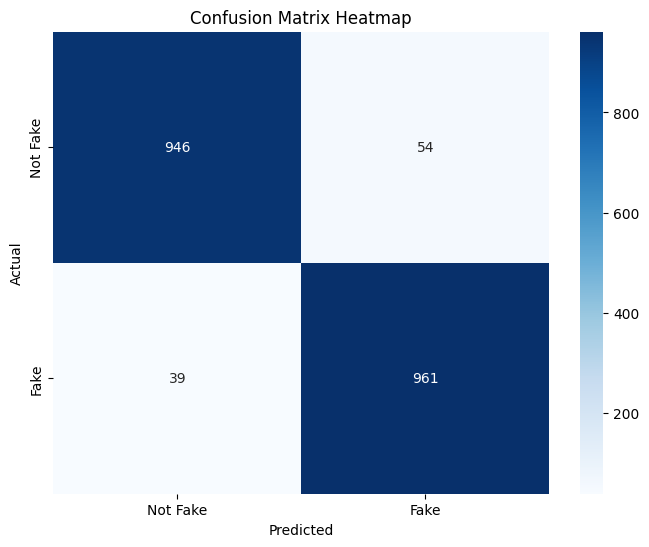

AUC-ROC: 0.9853


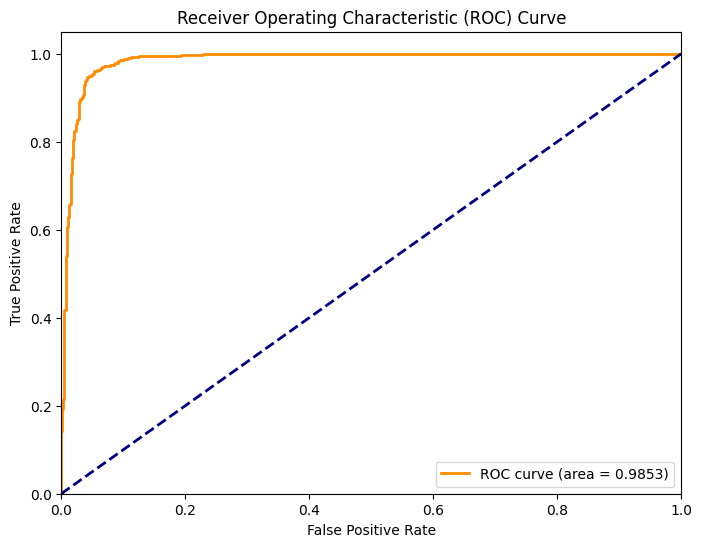

In [ ]:
#Choose cutout = 0.6 for best performance

# predict
y_pred = (y_prob>=0.6).astype(int)

# evaluation
print("Classification Report:")
print(classification_report(y_holdout, y_pred))

# confusion matrix
print("Confusion Matrix:")
cfm = confusion_matrix(y_holdout, y_pred)
print(cfm)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# AUC-ROC Calculation
y_pred_proba = logistic.predict_proba(X_holdout_vectorized)[:, 1]
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
with open('/content/drive/My Drive/digitalent/models/logistic.pkl', 'wb') as file:
    pickle.dump(logistic, file)
with open('/content/drive/My Drive/digitalent/models/logistic_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

### **PAC**

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/digitalent/data/clean/elongated_word_10k.csv')
X = df['news']
y = df['is_fake']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
pipe_pac = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("classifier", PassiveAggressiveClassifier(max_iter=1000, random_state=42)),
    ],
    verbose=True,
)

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=17, shuffle=True)

scoring = "accuracy"

scores_pac = cross_val_score(pipe_pac, X_train, y_train, scoring=scoring, cv=cv)
print(f"{scoring}: %0.2f (+/- %0.2f)" % (scores_pac.mean(), scores_pac.std() * 2))

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.9s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
accuracy: 0.95 (+/- 0.01)


In [ ]:
pipe_pac.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   1.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', PassiveAggressiveClassifier(random_state=42))],
         verbose=True)

In [ ]:
with open('/content/drive/My Drive/digitalent/models/pac_pipeline.pkl', 'wb') as file:
    pickle.dump(pipe_pac, file)

In [ ]:
with open('/content/drive/My Drive/digitalent/models/pac_pipeline.pkl', 'rb') as file:
    pipe_pac = pickle.load(file)


Holdout Accuracy: 0.9545

Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1000
           1       0.94      0.97      0.96      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Confusion Matrix:
[[942  58]
 [ 33 967]]


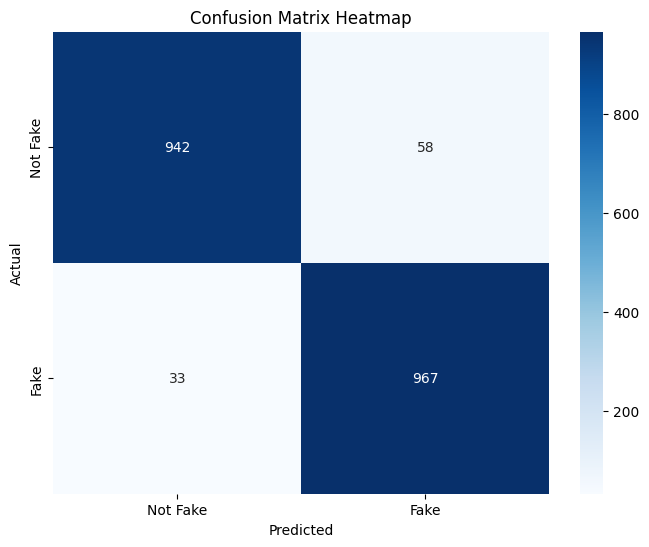

AUC-ROC: 0.9877


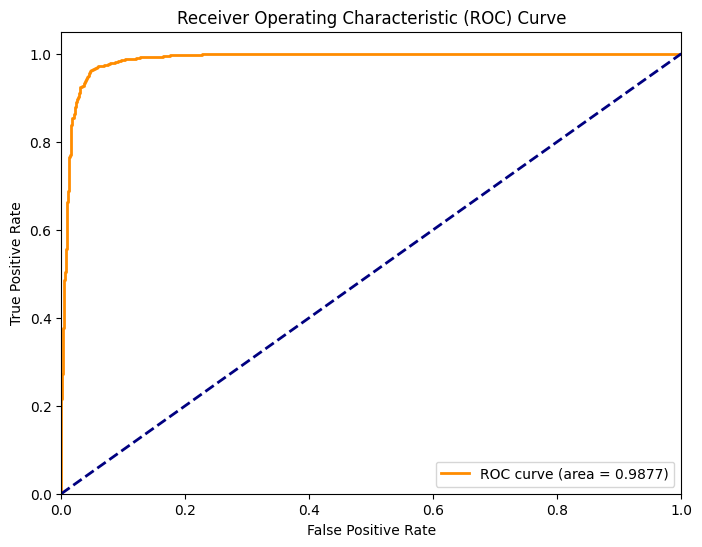

In [ ]:
y_pred = pipe_pac.predict(X_holdout)
print("\nHoldout Accuracy:", accuracy_score(y_holdout, y_pred))
print("\nClassification Report on Holdout Set:")
print(classification_report(y_holdout, y_pred))

# confusion matrix
print("Confusion Matrix:")
cfm = confusion_matrix(y_holdout, y_pred)
print(cfm)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# AUC-ROC Calculation
y_pred_proba = pipe_pac.decision_function(X_holdout)
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### **SVM**

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/elongated_word_10k.csv')
X = df['news']
y = df['is_fake']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
pipe_svm = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("classifier", SVC(probability=True, random_state=17)),
    ],
    verbose=True,
)

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=17, shuffle=True)

scoring = "accuracy"

scores_svm = cross_val_score(pipe_svm, X_train, y_train, scoring=scoring, cv=cv)
print(f"{scoring}: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 1.8min
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 1.9min
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   1.2s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 1.8min
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 1.8min
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.7s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 1.9min
accuracy: 0.95 (+/- 0.01)


In [ ]:
pipe_svm.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   1.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 2.4min


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', SVC(probability=True, random_state=17))],
         verbose=True)

In [ ]:
with open('/content/drive/My Drive/digitalent/models/svc_pipeline.pkl', 'wb') as file:
    pickle.dump(pipe_svm, file)


Holdout Accuracy: 0.9535

Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1000
           1       0.93      0.99      0.96      1000

    accuracy                           0.95      2000
   macro avg       0.96      0.95      0.95      2000
weighted avg       0.96      0.95      0.95      2000

Confusion Matrix:
[[920  80]
 [ 13 987]]


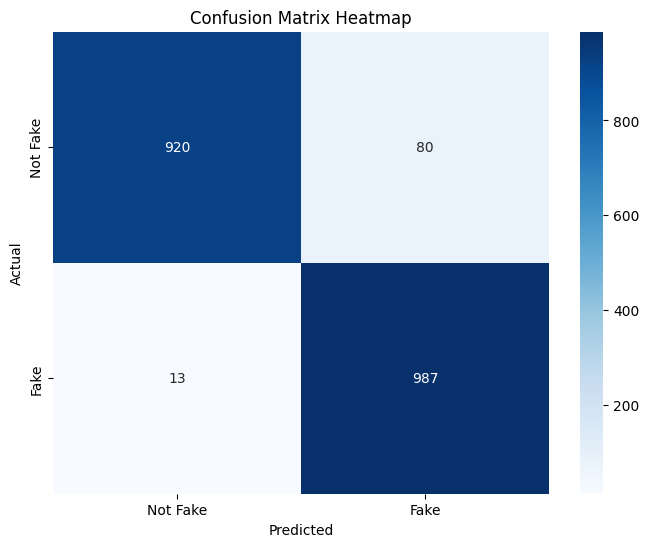

AUC-ROC: 0.9865


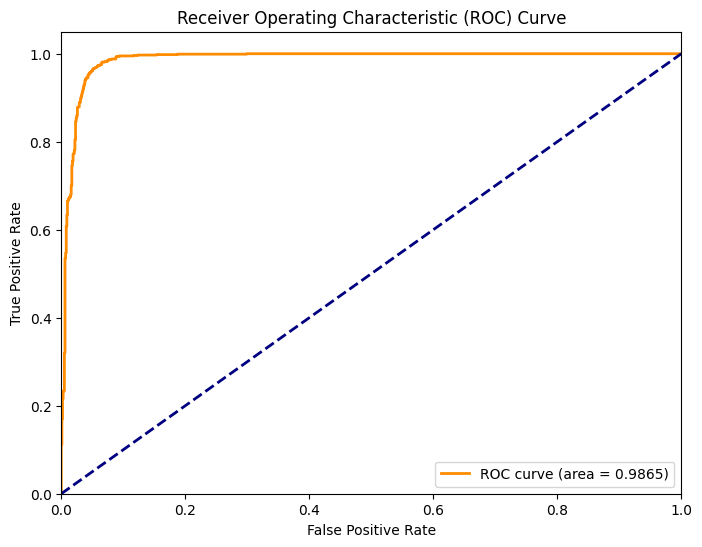

In [ ]:
y_pred = pipe_svm.predict(X_holdout)
print("\nHoldout Accuracy:", accuracy_score(y_holdout, y_pred))
print("\nClassification Report on Holdout Set:")
print(classification_report(y_holdout, y_pred))

# confusion matrix
print("Confusion Matrix:")
cfm = confusion_matrix(y_holdout, y_pred)
print(cfm)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# AUC-ROC Calculation
y_pred_proba = pipe_svm.predict_proba(X_holdout)[:, 1]
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### **Decision Tree**

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1000
           1       0.92      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Confusion Matrix:
[[915  85]
 [ 77 923]]


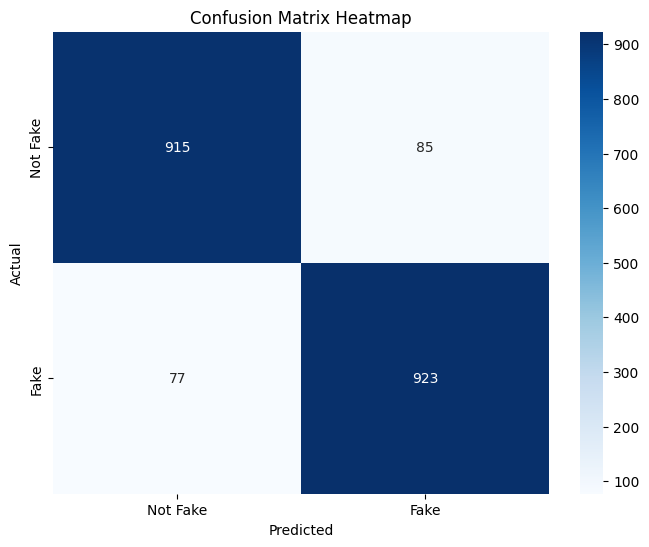

AUC-ROC: 0.9190


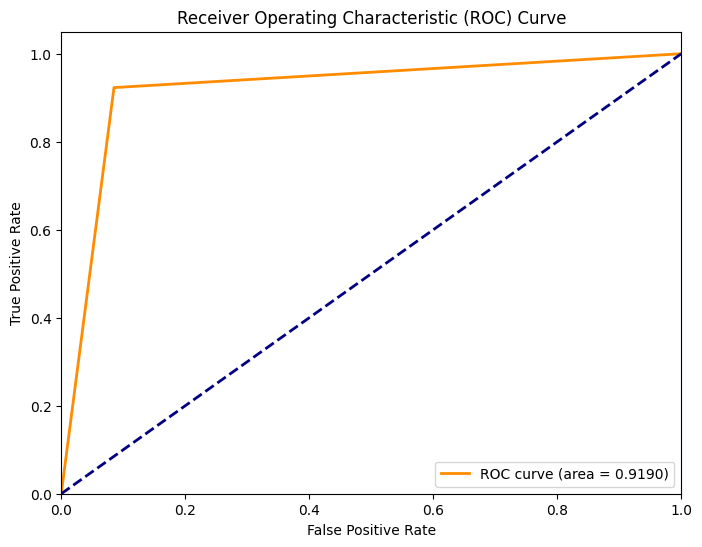

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# load data
data = pd.read_csv('/content/drive/MyDrive/data/elongated_word_10k.csv')
X = data["news"]
y = data["is_fake"]

# vectorize with TF-IDF
tfidf = TfidfVectorizer()
X_vectorized = tfidf.fit_transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42, stratify=y)

# model
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_model.fit(X_train, y_train)

# predict
y_pred = dtc_model.predict(X_test)

# evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
print("Confusion Matrix:")
cfm = confusion_matrix(y_test, y_pred)
print(cfm)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# AUC-ROC Calculation
y_pred_proba = dtc_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# save model
model_pkl_file = "/content/drive/MyDrive/data/decision_tree_model.pkl"
with open(model_pkl_file, 'wb') as file:
    pickle.dump(dtc_model, file)
with open('/content/drive/MyDrive/data/decision_tree_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      4729
           1       0.96      0.93      0.94      5271

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Confusion Matrix:
[[4515  214]
 [ 359 4912]]


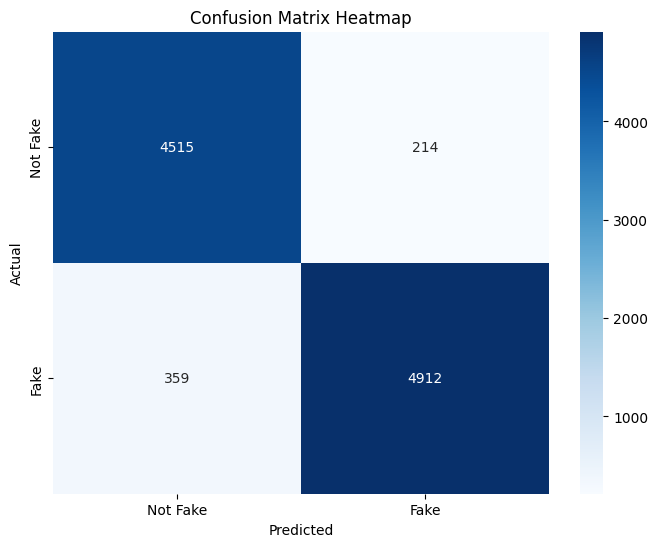

AUC-ROC: 0.9190


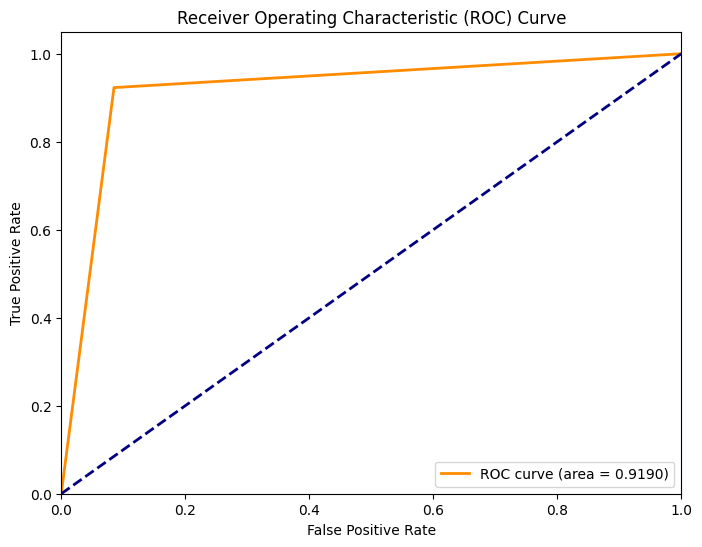

In [ ]:
import pickle
from sklearn.metrics import classification_report, confusion_matrix

# load model and vectorizer
with open('/content/drive/MyDrive/data/decision_tree_model.pkl', 'rb') as f:
    dtc_model = pickle.load(f)
with open('/content/drive/MyDrive/data/decision_tree_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

# load data
data = pd.read_csv('/content/drive/MyDrive/data/val_10k.csv')
X = data['news']
y = data['is_fake']

# vectorize with TF-IDF
X_vectorized = tfidf.transform(X)

# predict
y_pred = (dtc_model.predict(X_vectorized) > 0.5).astype("int32")

# evaluation
print("Classification Report:")
print(classification_report(y, y_pred))

# confusion matrix
print("Confusion Matrix:")
cfm = confusion_matrix(y, y_pred)
print(cfm)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# AUC-ROC Calculation
y_pred_proba = dtc_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### **Random Forest**

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1000
           1       0.92      0.97      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Confusion Matrix:
[[912  88]
 [ 27 973]]


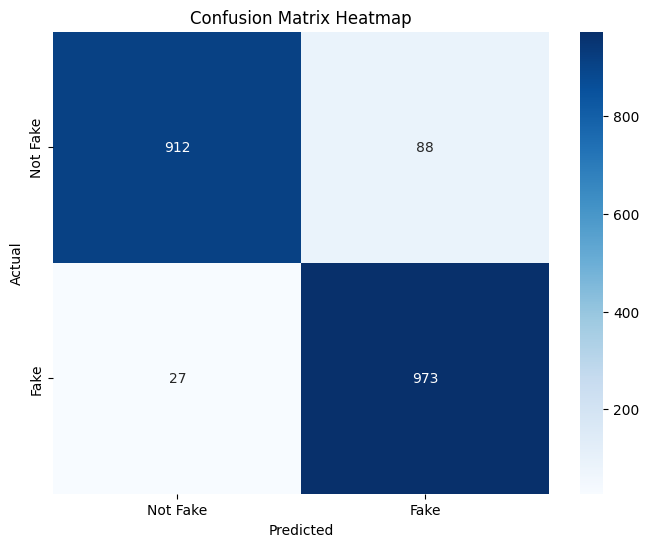

AUC-ROC: 0.9811


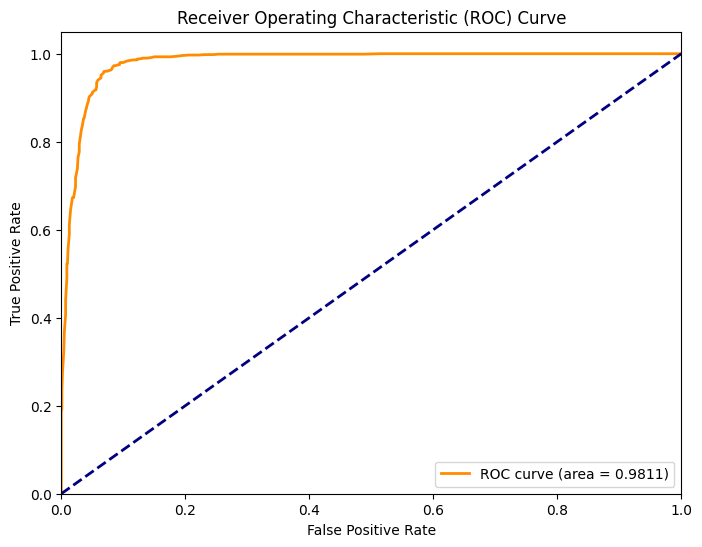

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# load data
data = pd.read_csv('/content/drive/MyDrive/data/elongated_word_10k.csv')
X = data["news"]
y = data["is_fake"]

# vectorize with TF-IDF
tfidf = TfidfVectorizer()
X_vectorized = tfidf.fit_transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42, stratify=y)

# model
rfc_model = RandomForestClassifier(random_state=42)
rfc_model.fit(X_train, y_train)

# predict
y_pred = rfc_model.predict(X_test)

# evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
print("Confusion Matrix:")
cfm = confusion_matrix(y_test, y_pred)
print(cfm)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# AUC-ROC Calculation
y_pred_proba = rfc_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# save model
model_pkl_file = "/content/drive/MyDrive/data/random_forest_model.pkl"
with open(model_pkl_file, 'wb') as file:
    pickle.dump(rfc_model, file)
with open('/content/drive/MyDrive/data/random_forest_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4729
           1       0.96      0.98      0.97      5271

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix:
[[4533  196]
 [ 129 5142]]


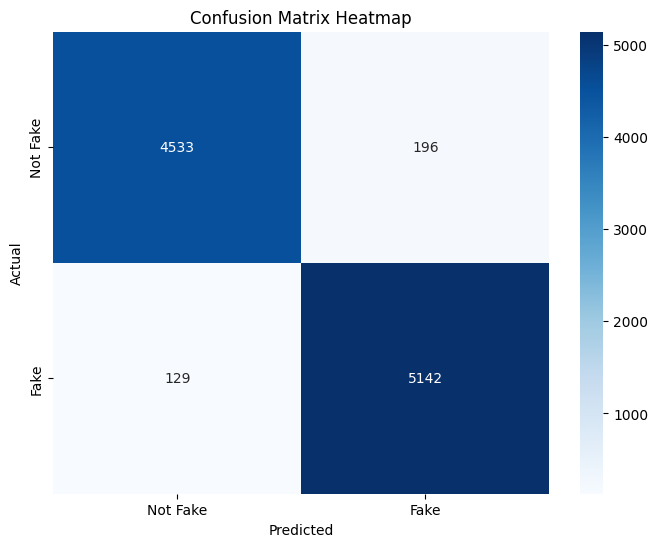

AUC-ROC: 0.9811


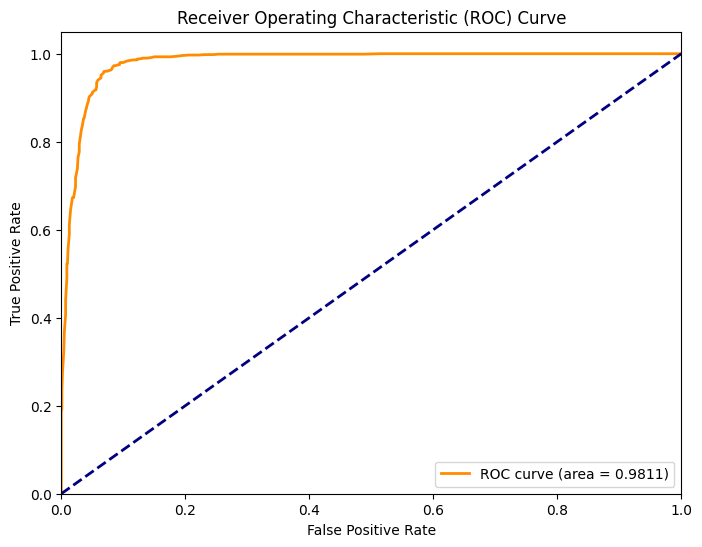

In [ ]:
import pickle
from sklearn.metrics import classification_report, confusion_matrix

# load model and vectorizer
with open('/content/drive/MyDrive/data/random_forest_model.pkl', 'rb') as f:
    rfc_model = pickle.load(f)
with open('/content/drive/MyDrive/data/random_forest_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

# load data
data = pd.read_csv('/content/drive/MyDrive/data/val_10k.csv')
X = data['news']
y = data['is_fake']

# vectorize with TF-IDF
X_vectorized = tfidf.transform(X)

# predict
y_pred = (rfc_model.predict(X_vectorized) > 0.5).astype("int32")

# evaluation
print("Classification Report:")
print(classification_report(y, y_pred))

# confusion matrix
print("Confusion Matrix:")
cfm = confusion_matrix(y, y_pred)
print(cfm)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# AUC-ROC Calculation
y_pred_proba = rfc_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### **Gradient Boosting**

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1000
           1       0.90      0.97      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

Confusion Matrix:
[[895 105]
 [ 30 970]]


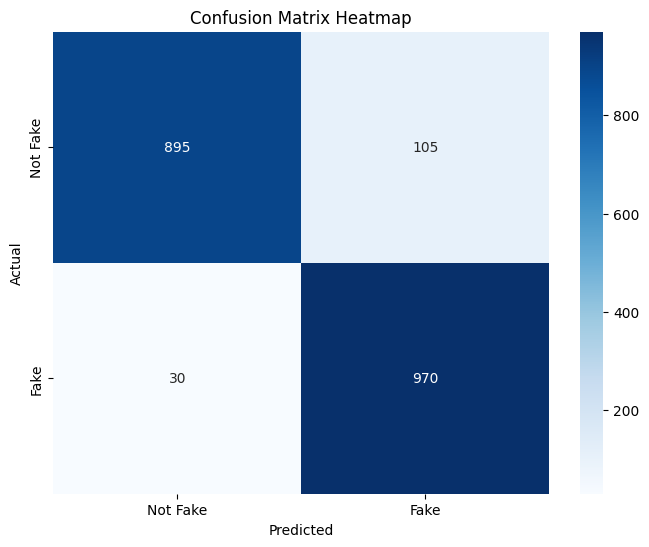

AUC-ROC: 0.9763


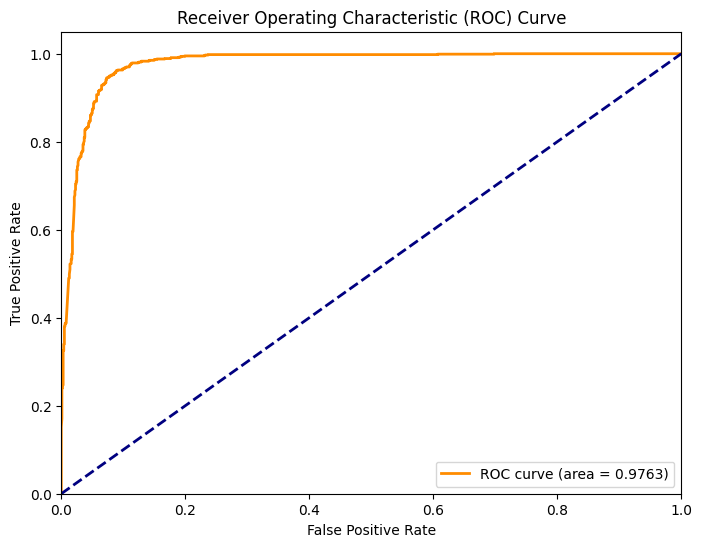

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# load data
data = pd.read_csv('/content/drive/MyDrive/data/elongated_word_10k.csv')
X = data["news"]
y = data["is_fake"]

# vectorize with TF-IDF
tfidf = TfidfVectorizer()
X_vectorized = tfidf.fit_transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42, stratify=y)

# model
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)

# predict
y_pred = gbc_model.predict(X_test)

# evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
print("Confusion Matrix:")
cfm = confusion_matrix(y_test, y_pred)
print(cfm)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# AUC-ROC Calculation
y_pred_proba = gbc_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# save model
model_pkl_file = "/content/drive/MyDrive/data/gradient_boosting_model.pkl"
with open(model_pkl_file, 'wb') as file:
    pickle.dump(gbc_model, file)
with open('/content/drive/MyDrive/data/gradient_boosting_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4729
           1       0.95      0.97      0.96      5271

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Confusion Matrix:
[[4438  291]
 [ 151 5120]]


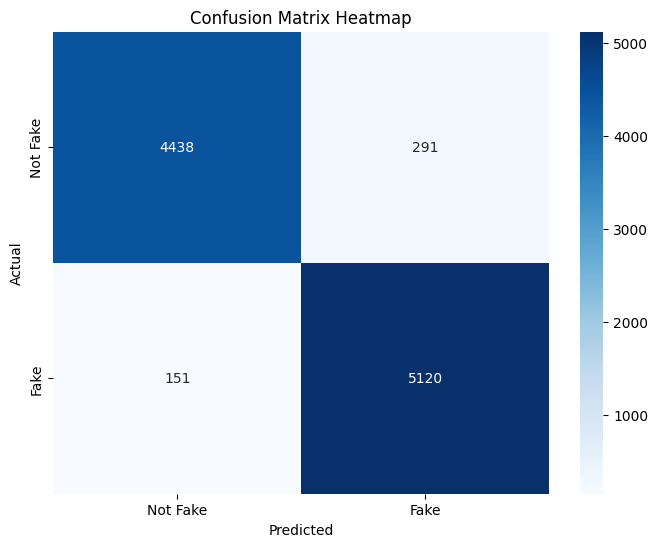

AUC-ROC: 0.9763


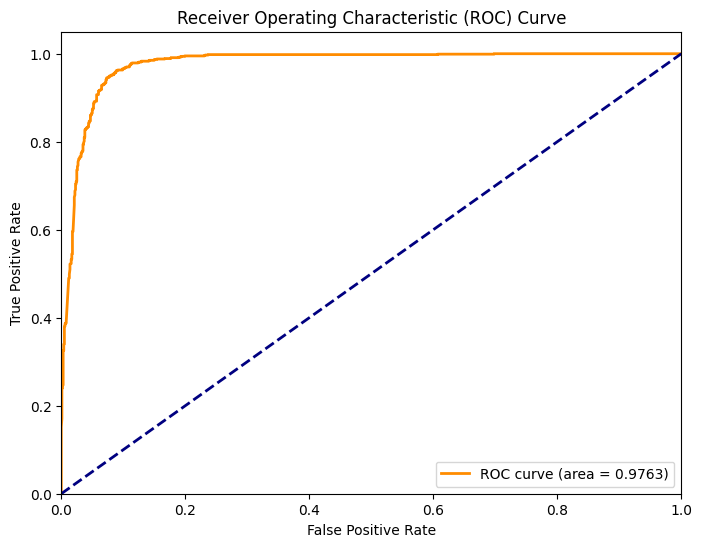

In [ ]:
import pickle
from sklearn.metrics import classification_report, confusion_matrix

# load model and vectorizer
with open('/content/drive/MyDrive/data/gradient_boosting_model.pkl', 'rb') as f:
    gbc_model = pickle.load(f)
with open('/content/drive/MyDrive/data/gradient_boosting_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

# load data
data = pd.read_csv('/content/drive/MyDrive/data/val_10k.csv')
X = data['news']
y = data['is_fake']

# vectorize with TF-IDF
X_vectorized = tfidf.transform(X)

# predict
y_pred = (gbc_model.predict(X_vectorized) > 0.5).astype("int32")

# evaluation
print("Classification Report:")
print(classification_report(y, y_pred))

# confusion matrix
print("Confusion Matrix:")
cfm = confusion_matrix(y, y_pred)
print(cfm)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# AUC-ROC Calculation
y_pred_proba = gbc_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### **XGBoost**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Modify this
TRAIN_DATASET_PATH = '/content/drive/MyDrive/digitalent/data/clean/elongated_word_10k.csv'
VALIDATION_DATASET_PATH = '/content/drive/MyDrive/digitalent/data/clean/val_10k.csv'
MODEL_SAVE_PATH = '/content/drive/MyDrive/digitalent/models/xgboost_pipeline.pkl'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from xgboost import XGBClassifier

In [ ]:
data = pd.read_csv(TRAIN_DATASET_PATH)
data['news'] = data['news'].astype(str)
X = data['news']
y = data['is_fake']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
pipe_xgboost = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("classifier", XGBClassifier(eval_metric='logloss', random_state=42)),
    ],
    verbose=True,
)

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

scoring = "accuracy"

scores_xgboost = cross_val_score(pipe_xgboost, X_train, y_train, scoring=scoring, cv=cv)
print(f"{scoring}: %0.2f (+/- %0.2f)" % (scores_xgboost.mean(), scores_xgboost.std() * 2))

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.9s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  20.7s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  19.0s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   1.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  20.3s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  35.0s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   1.7s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  27.0s
accuracy: 0.95 (+/- 0.01)


In [ ]:
pipe_xgboost.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   1.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  30.9s


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))],
         verbose=True)

In [ ]:
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(pipe_xgboost, file)

In [ ]:
with open(MODEL_SAVE_PATH, 'rb') as file:
    pipe_xgboost = pickle.load(file)

In [ ]:
val_data = pd.read_csv(VALIDATION_DATASET_PATH)
val_data['news'] = val_data['news'].astype(str)
X_val = val_data['news']
y_val = val_data['is_fake']


Holdout Accuracy: 0.95

Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1000
           1       0.93      0.97      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



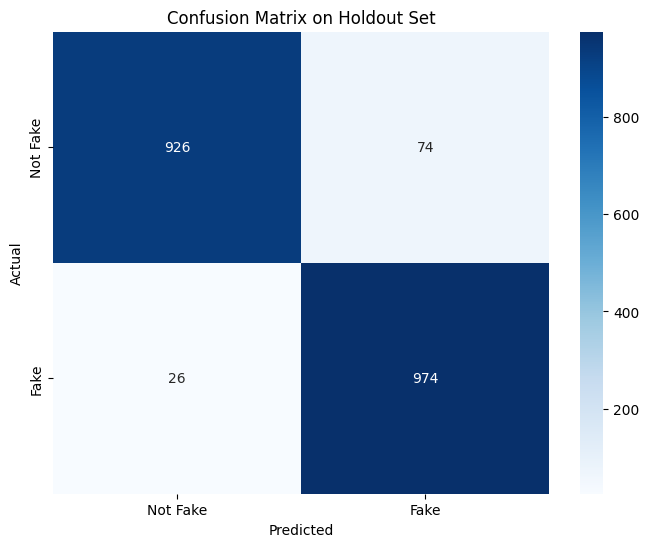

AUC-ROC: 0.9870


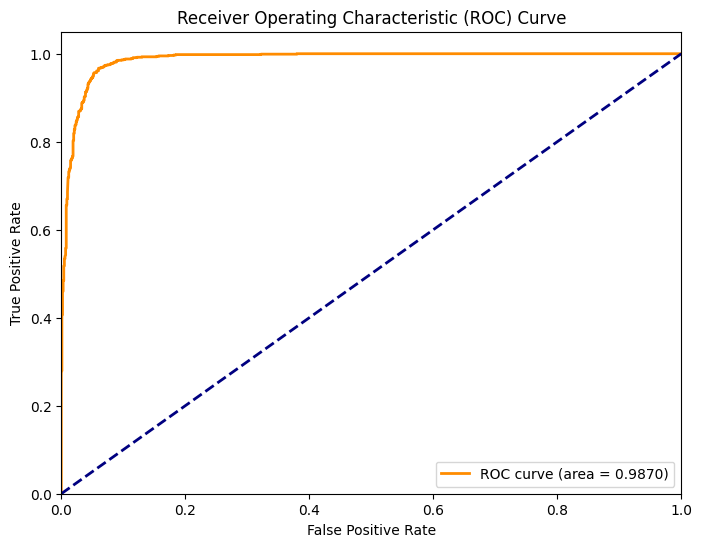

In [ ]:
y_pred = pipe_xgboost.predict(X_holdout)
print("\nHoldout Accuracy:", accuracy_score(y_holdout, y_pred))
print("\nClassification Report on Holdout Set:")
print(classification_report(y_holdout, y_pred))
cfm = confusion_matrix(y_holdout, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Holdout Set')
plt.show()

# AUC-ROC Calculation
y_pred_proba = pipe_xgboost.predict_proba(X_holdout)[:, 1]
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Validation Accuracy: 0.9719

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4729
           1       0.97      0.98      0.97      5271

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



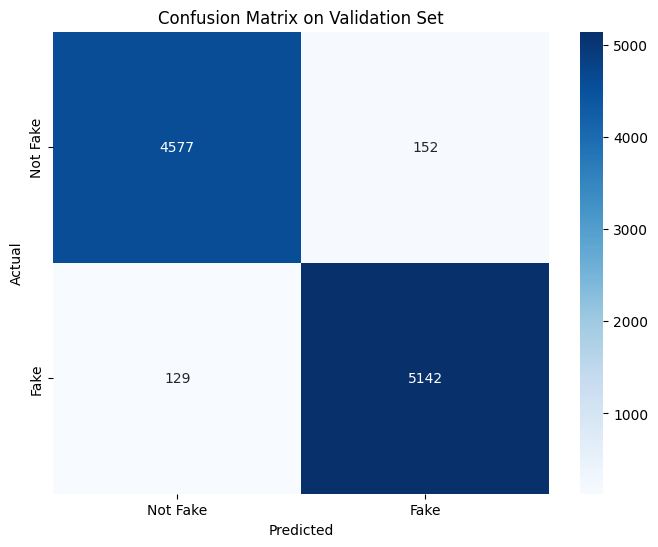

In [ ]:
y_val_pred = pipe_xgboost.predict(X_val)
print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))
cfm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm_val, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()